In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import geone.geosclassicinterface as gci
import pyvista as pv
import sys
import scipy

import os

import shapely
from shapely.geometry import Polygon, LineString, MultiPolygon, MultiLineString
import rasterio
import rasterio.features
from rasterio import Affine

sys.path.append("../")
import EROS
from EROS import plot_bh

%load_ext autoreload
%autoreload 2

In [4]:
ox = 0
nx = 180
sx = .3334
nz = 200
sz = 0.15
oz = 0

xg = np.arange(ox, ox+sx*(nx+1), sx)
xgc = np.linspace(ox+sx/2, ox+sx*nx-sx/2, nx)
zgc = np.linspace(oz+sz/2, oz+sz*nz-sz/2, nz)
plot_xg = np.linspace(ox, ox+nx*sx, nx)

z1 = oz+nz*sz
x1 = ox + nx*sx

# parameters
var = 5
r = 15
xi = 0.1
alpha = 0.5

N = 100
np.random.seed(15)
means = np.sort(np.random.uniform(0, z1+5, N))

cm = gcm.CovModel1D(elem=[("cubic", {"w":var, "r":r})])

In [5]:
import EROS

### Xi effect

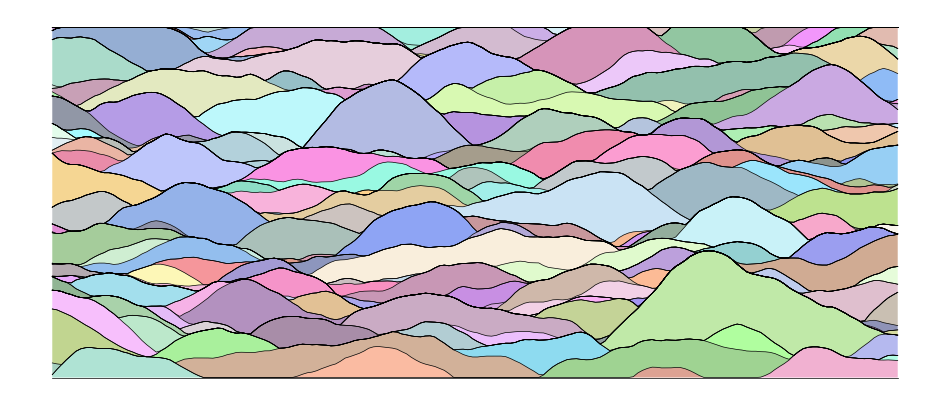

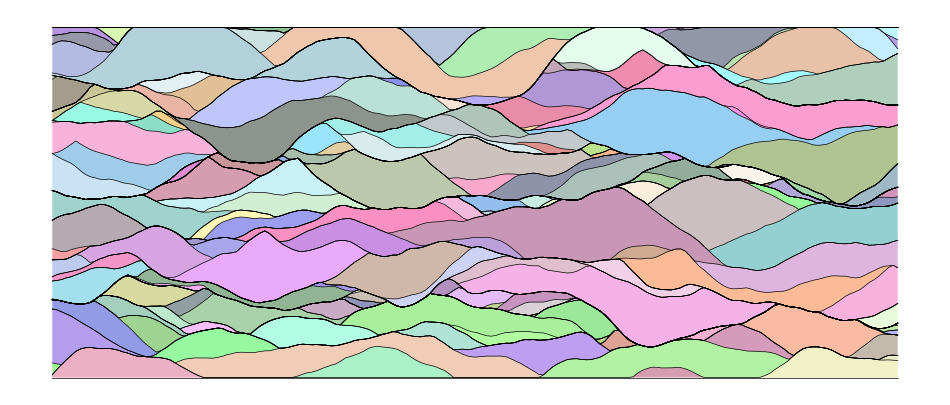

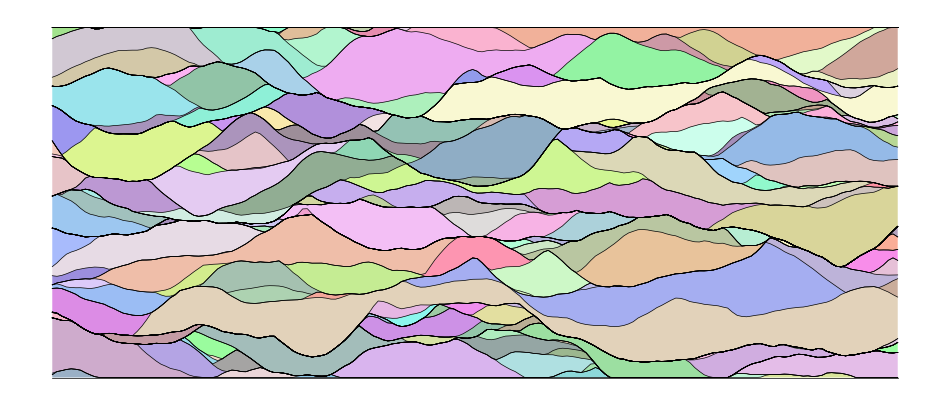

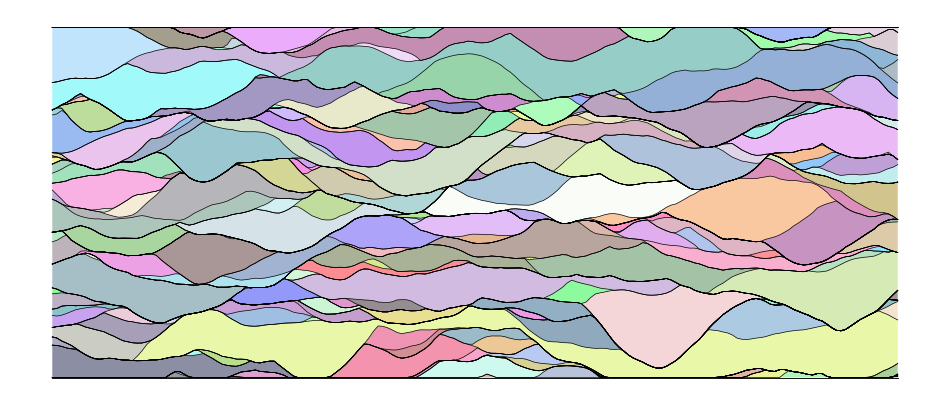

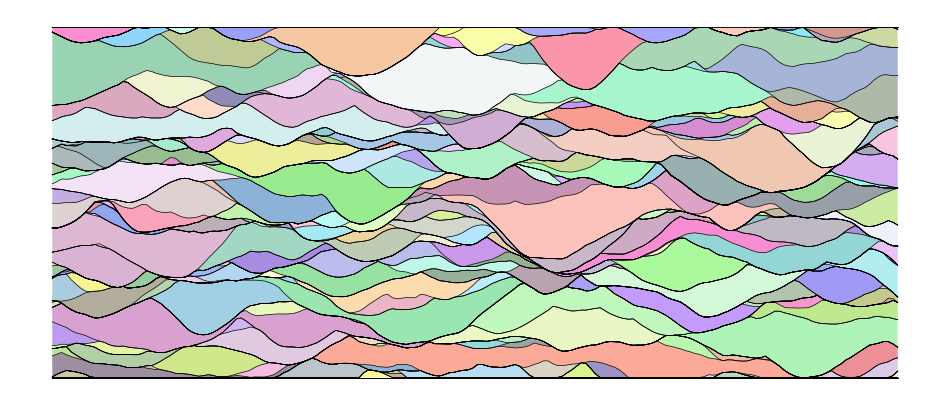

In [12]:
for xi in [0, 0.1, 0.3, 0.5, 0.8]:
    real_surf, arr_res, list_p_cond = EROS.sim_uncond_2D(N, cm, means,
                                          (nx, nz), (sx, sz), (ox, oz), alpha=0, xi=xi, seed=1)
    
    new_shape = MultiPolygon(list_p_cond[:])

    fig, axs = plt.subplots(figsize=(12,5), dpi=100)

    i=0
    for geom in new_shape.geoms: 
        xs, ys = geom.exterior.xy    
        axs.fill(xs, ys, alpha=.45, fc=np.random.random(3), ec='none')        
        i += 1
    
    plt.plot(np.linspace(0, x1, nx), real_surf.T, c="k", linewidth=.5)
    #plt.title(r"$\xi = {}$".format(xi))
    plt.axis('off')

In [13]:
matplotlib.rcParams.update({'font.size': 16})

In [14]:
w_logs = [(5, 30, [(1, z1), (2, z1-7), (3, z1-12), (1, z1-20)]),
        (25, 20, [(2, z1), (1, z1-8), (3, z1-16)]),
         (55, 23, [(2, z1), (1, z1-7), (3, z1-18)])]

CPU times: total: 23.6 s
Wall time: 2.43 s


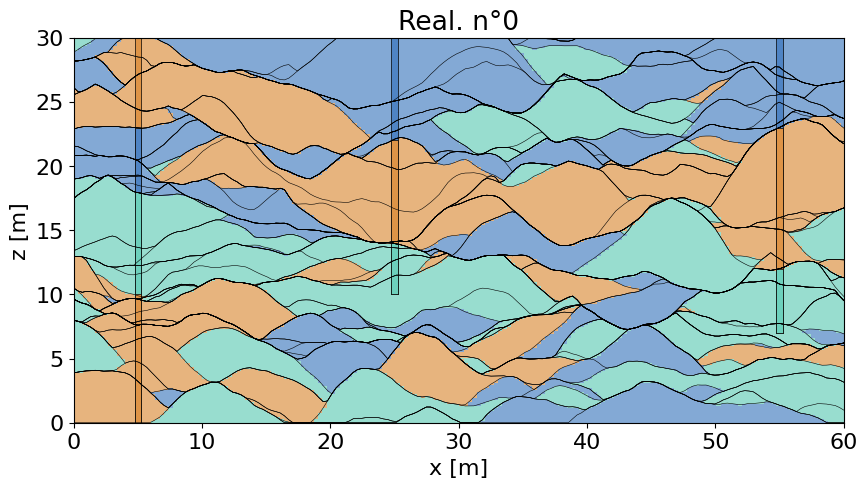

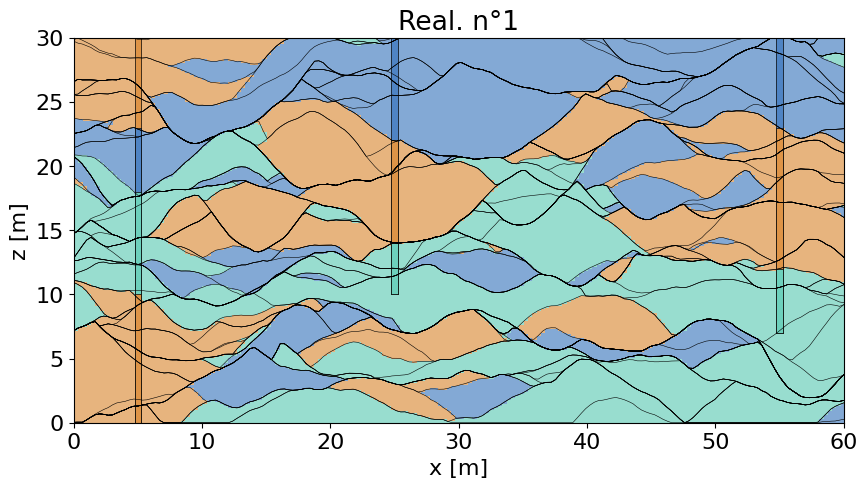

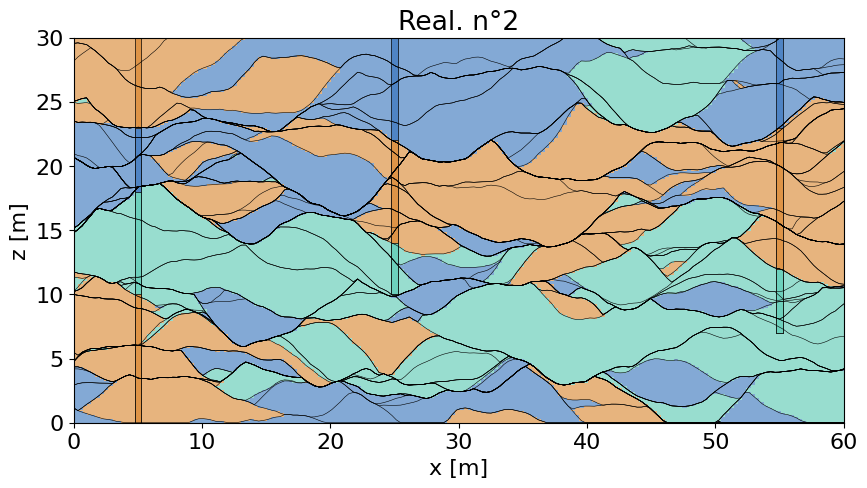

In [15]:
%%time

N = 100
np.random.seed(14)
means = np.sort(np.random.uniform(0, z1+5, N))

nreal = 3
for ireal in range(nreal):
    
    seed = 14 + ireal * 13
    
    real_surf, arr_res, list_p_cond = EROS.sim_cond_2D(N, cm, means,
                                          (nx, nz), (sx, sz), (ox, oz), w_logs, alpha=alpha, 
                                                       xi=0.1, seed=seed, plots=False, verbose=1,
                                                       facies_ids=[1, 2, 3], proba_cdf=[0.33, 0.33, 0.33])
    
    arr_plot = np.zeros([nz, nx, 3])
    for ival in np.unique(arr_res):
        np.random.seed(ival+24)
        arr_plot[arr_res==ival] = np.random.random(size=3)
    
    np.random.seed()
    
    fig, axs = plt.subplots(figsize=(10,5), dpi=100)
    plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
    plt.plot(plot_xg, real_surf.T, c="k", linewidth=.4)
    plt.xlabel("x [m]")
    plt.ylabel("z [m]")
    plt.title("Real. n°{}".format(ireal))
    plot_bh(w_logs, 0.5)
    

In [16]:
import EROS

### probas

In [17]:
N = 100
np.random.seed(15)

seed = np.random.randint(1e6)
means = np.sort(np.random.uniform(0, z1+5, N))

nreal = 100
sims = []
surfs = []
for ireal in range(nreal):
    print(ireal)
    seed = np.random.randint(1e6)
    real_surf, arr_res, list_p_cond = EROS.sim_cond_2D(N, cm, means,
                                          (nx, nz), (sx, sz), (ox, oz), w_logs, alpha=alpha, 
                                                      xi=0.1, seed=seed, plots=False, verbose=1,
                                                      facies_ids=[1, 2, 3], proba_cdf=[0.33, 0.33, 0.33])
    sims.append(arr_res.copy())
    surfs.append(real_surf.copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


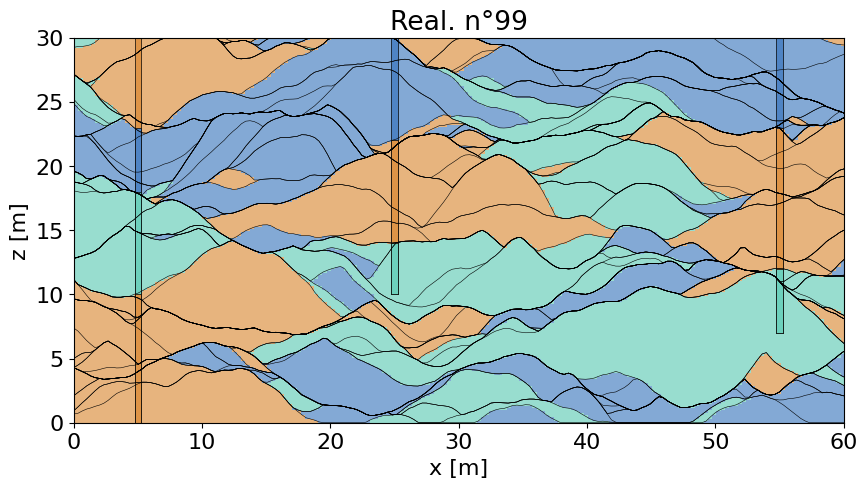

In [18]:
id_sim = 5
arr_res = sims[id_sim]
real_surf = surfs[id_sim]

arr_plot = np.zeros([nz, nx, 3])

for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)

fig, axs = plt.subplots(figsize=(10,5), dpi=100)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.4)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("Real. n°{}".format(ireal))
plot_bh(w_logs, 0.5)

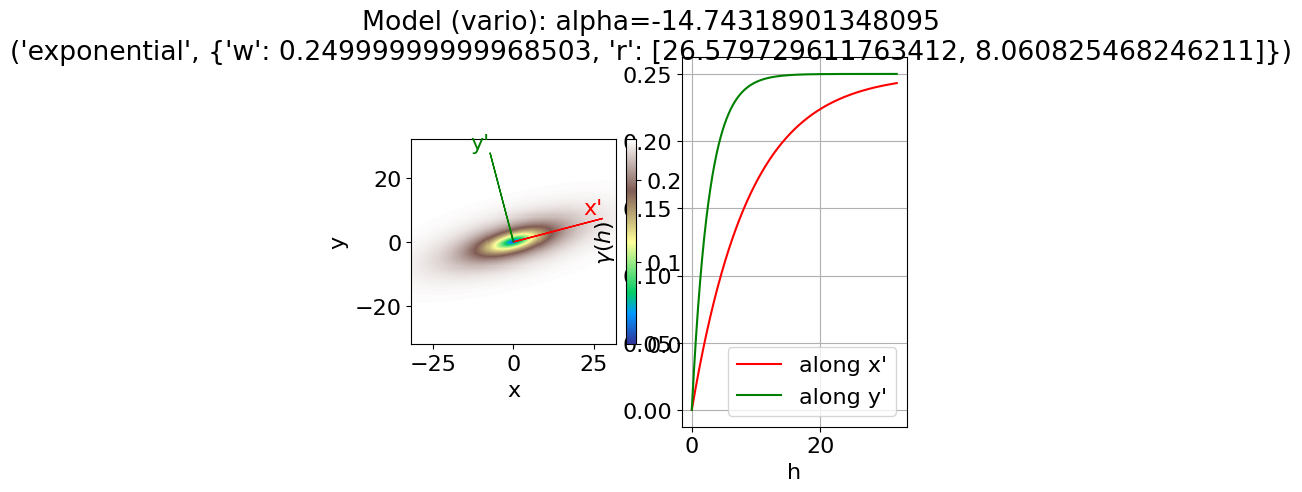

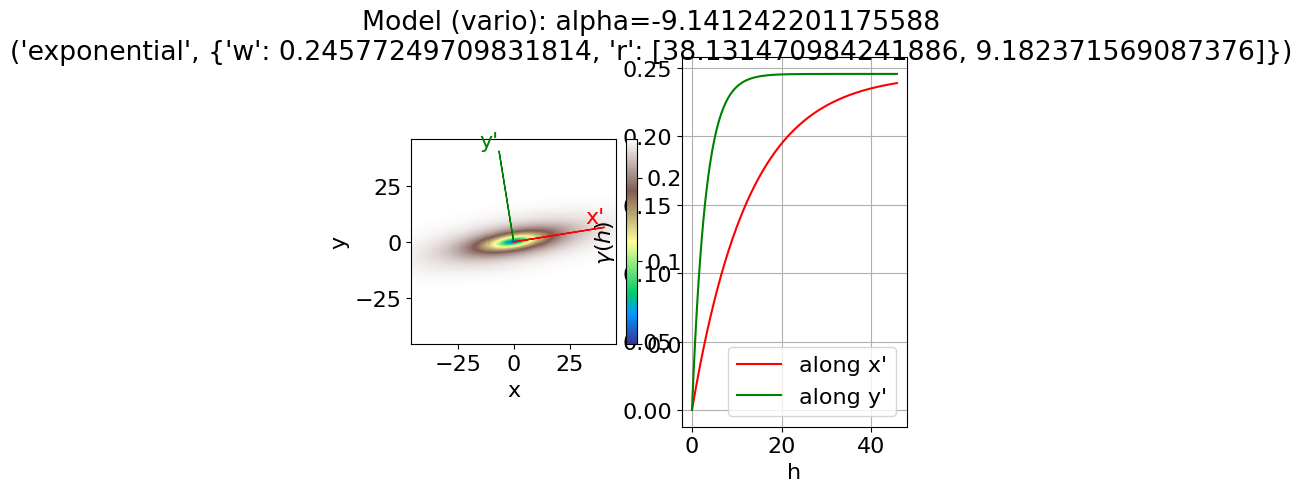

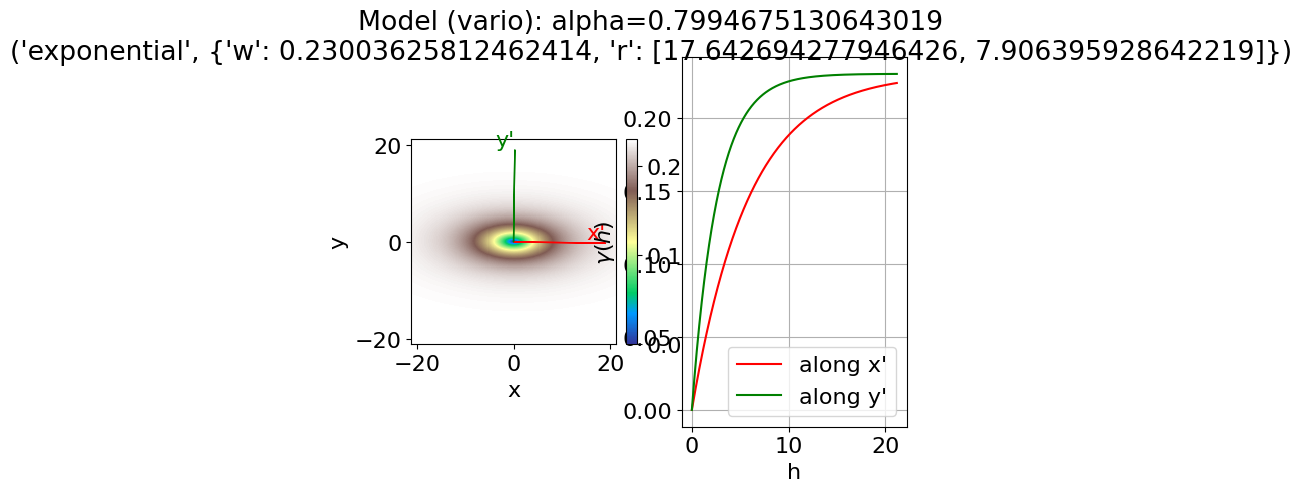

In [19]:
# get_cms for SIS

cm_list = []
for id_fa in range(1, 4):
    
    arr = sims[5].copy()
    arr[arr != id_fa] = 0
    arr[arr == id_fa] = 1

    im = geone.img.Img(nx = arr.shape[1], ny = arr.shape[0], nz=1, sx=sx, sy=sz, sz=1, ox=0, oy=0, oz=0, nv=1,
                  val=arr.reshape(1, 1, nz, nx), name="asdf")

    #geone.imgplot.drawImage2D(im)
    # geone.imgplot.drawImage2D(geone.geosclassicinterface.imgTwoPointStatisticsImage(im))
    v = arr.flatten()
    X, Y = np.meshgrid(xgc, zgc)
    xu = np.array([X.flatten(), Y.flatten()]).T
    n = 2000
    idx = np.random.choice(np.arange(nz*nx), size=n, replace=False)

    cm_fit = geone.covModel.CovModel2D(elem=[("exponential", {"w":np.nan, "r":[np.nan, np.nan]})], alpha=np.nan)

    bounds = ((0.01, 1, 1, -45), (0.25, 100, 100, 45))
#     bounds = ((0.01, 1, 1, -45), (0.25, 40, 40, 45))
    p0 = (0.1, 10, 10, 0)
    cm, popt = geone.covModel.covModel2D_fit(xu[idx], v[idx], cm_fit, bounds=bounds, p0=p0, hmax=20)
    cm_list.append(cm)

In [20]:
# data
x_data = []
v_data = []

for w in w_logs:
    
    for iz in np.arange(w[2][0][1], w[2][0][1] - w[1], -sz):
        
        iz -= sz/2
        
        pos_in_log = np.where((iz < np.array([i[1] for i in w[2]])))[0][-1]
        v_data.append(w[2][pos_in_log][0])
        x_data.append((w[0], iz))
        
x_data = np.array(x_data)
v_data = np.array(v_data)

In [21]:
sim_sis = geone.geosclassicinterface.simulateIndicator2D([1, 2, 3], cm_list, (nx, nz), (sx, sz), x=x_data, v=v_data,
                                                         seed=None, probability=(0.33, 0.33, 0.34), nreal=100)["image"]

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230419 / OpenMP 15 thread(s)]
Geos-Classic run complete


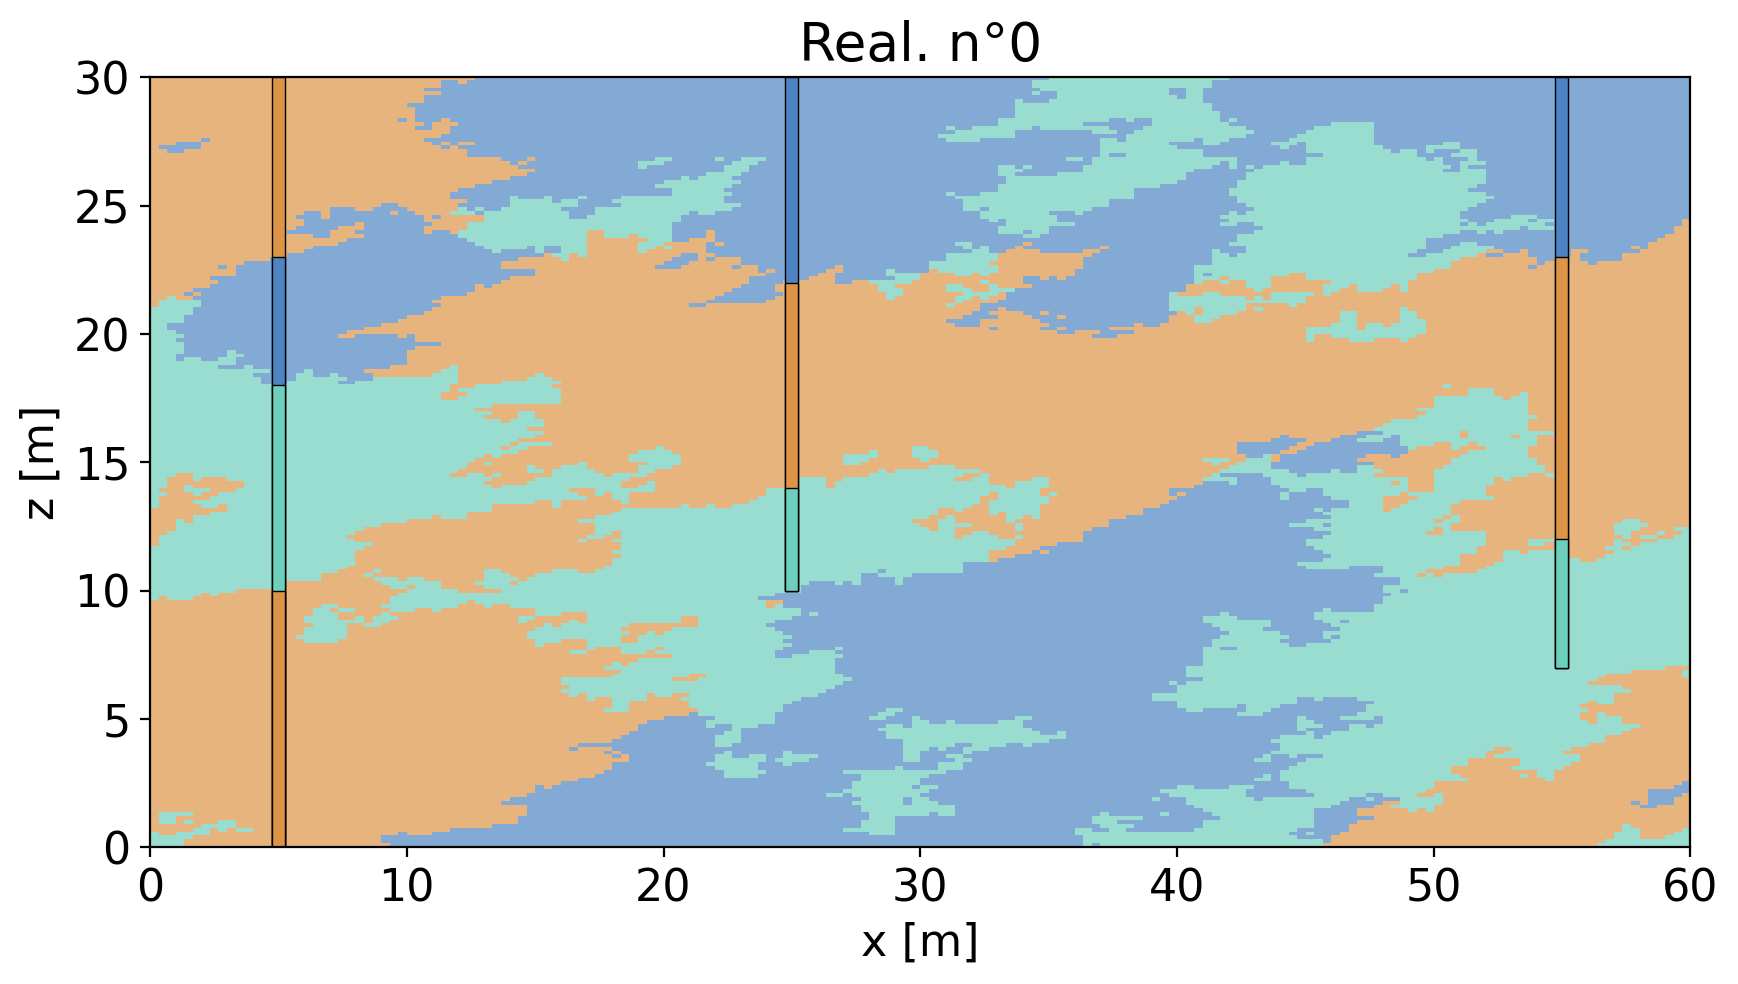

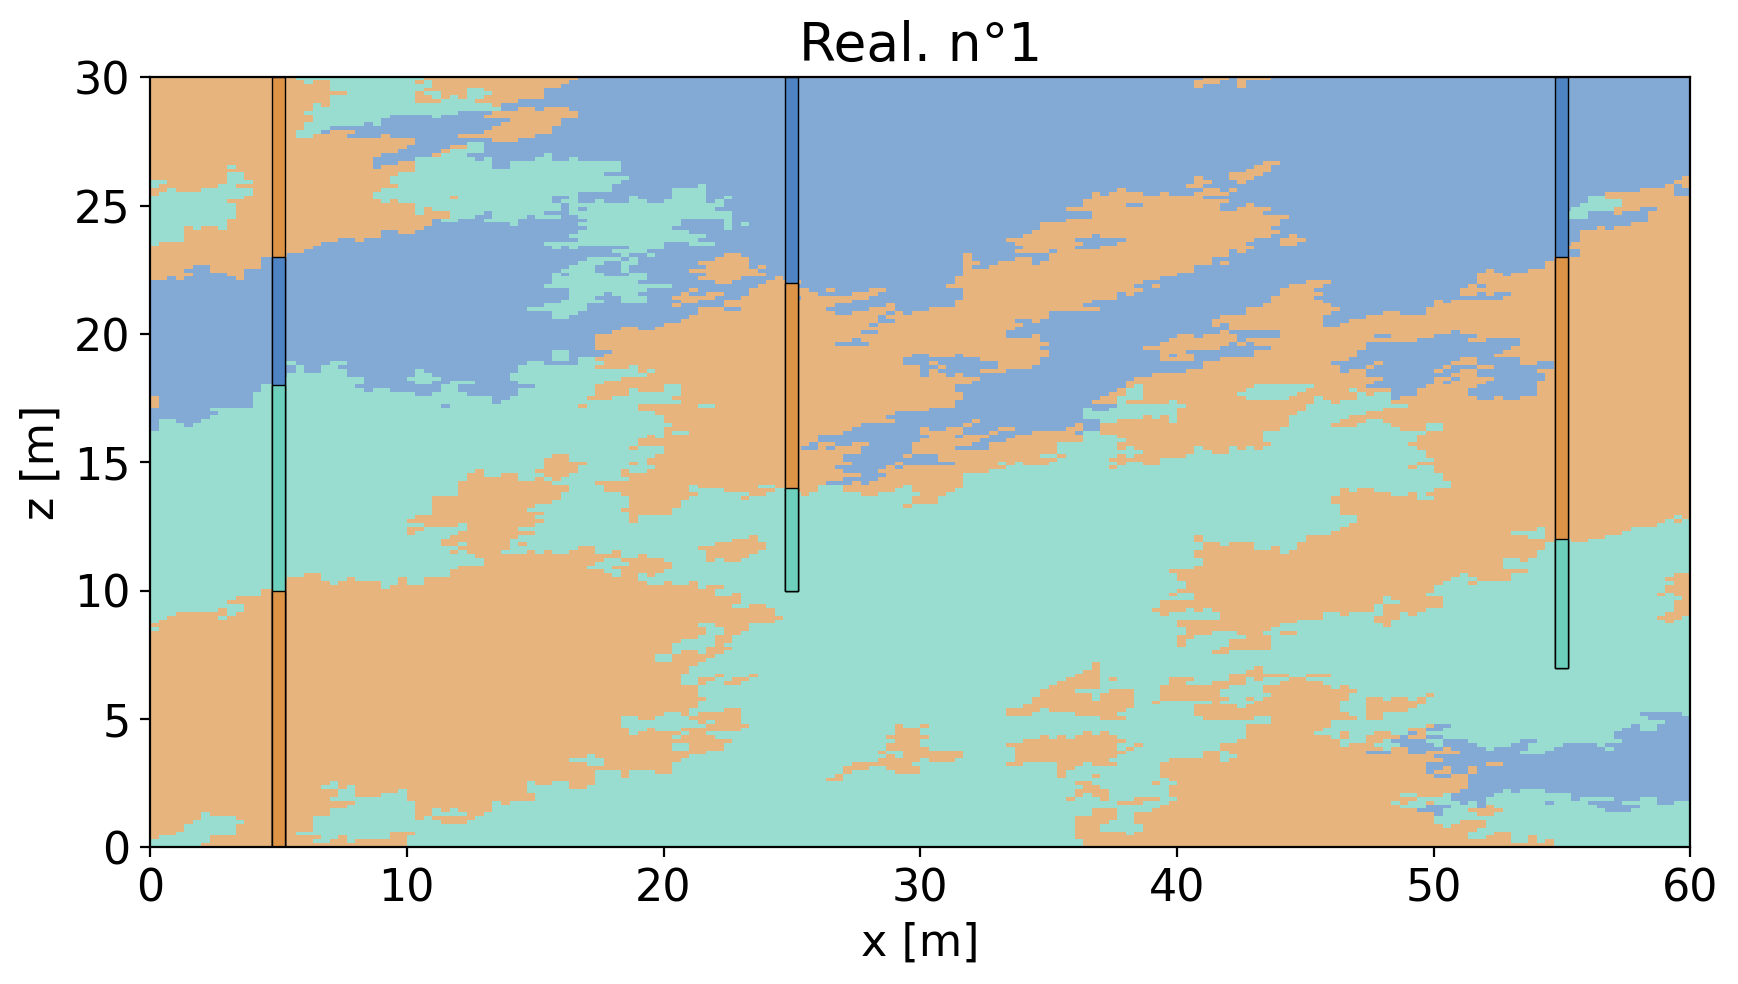

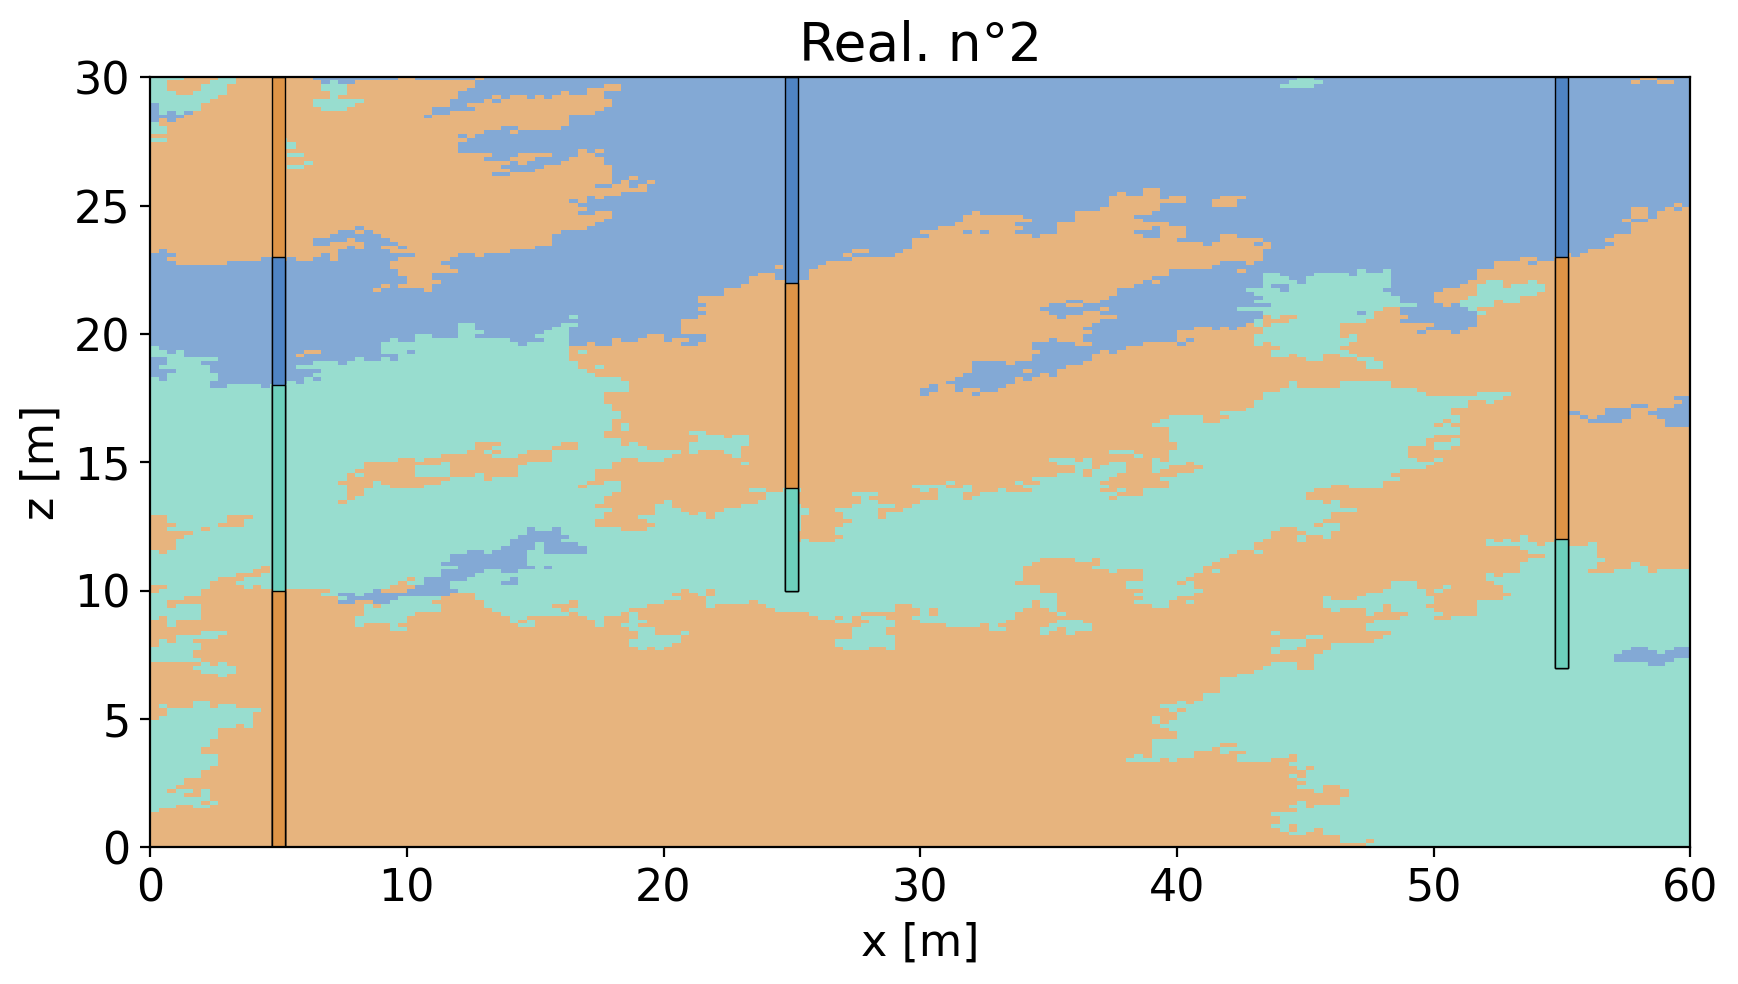

In [23]:
nreal = 3
for ireal in range(nreal):

    for ival in np.unique(sim_sis.val[ireal, 0]):
        np.random.seed(int(ival)+24)
        arr_plot[sim_sis.val[ireal, 0]==ival] = np.random.random(size=3)

    np.random.seed()
    
    fig, axs = plt.subplots(figsize=(10,5), dpi=200)
    plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
    plt.xlabel("x [m]")
    plt.ylabel("z [m]")
    plt.title("Real. n°{}".format(ireal))
    plot_bh(w_logs, 0.5)
    

In [24]:
sims = np.array(sims)

In [25]:
matplotlib.rcParams.update({'font.size': 10})

Text(0.5, 1.0, 'EROS: Shannon Entropy')

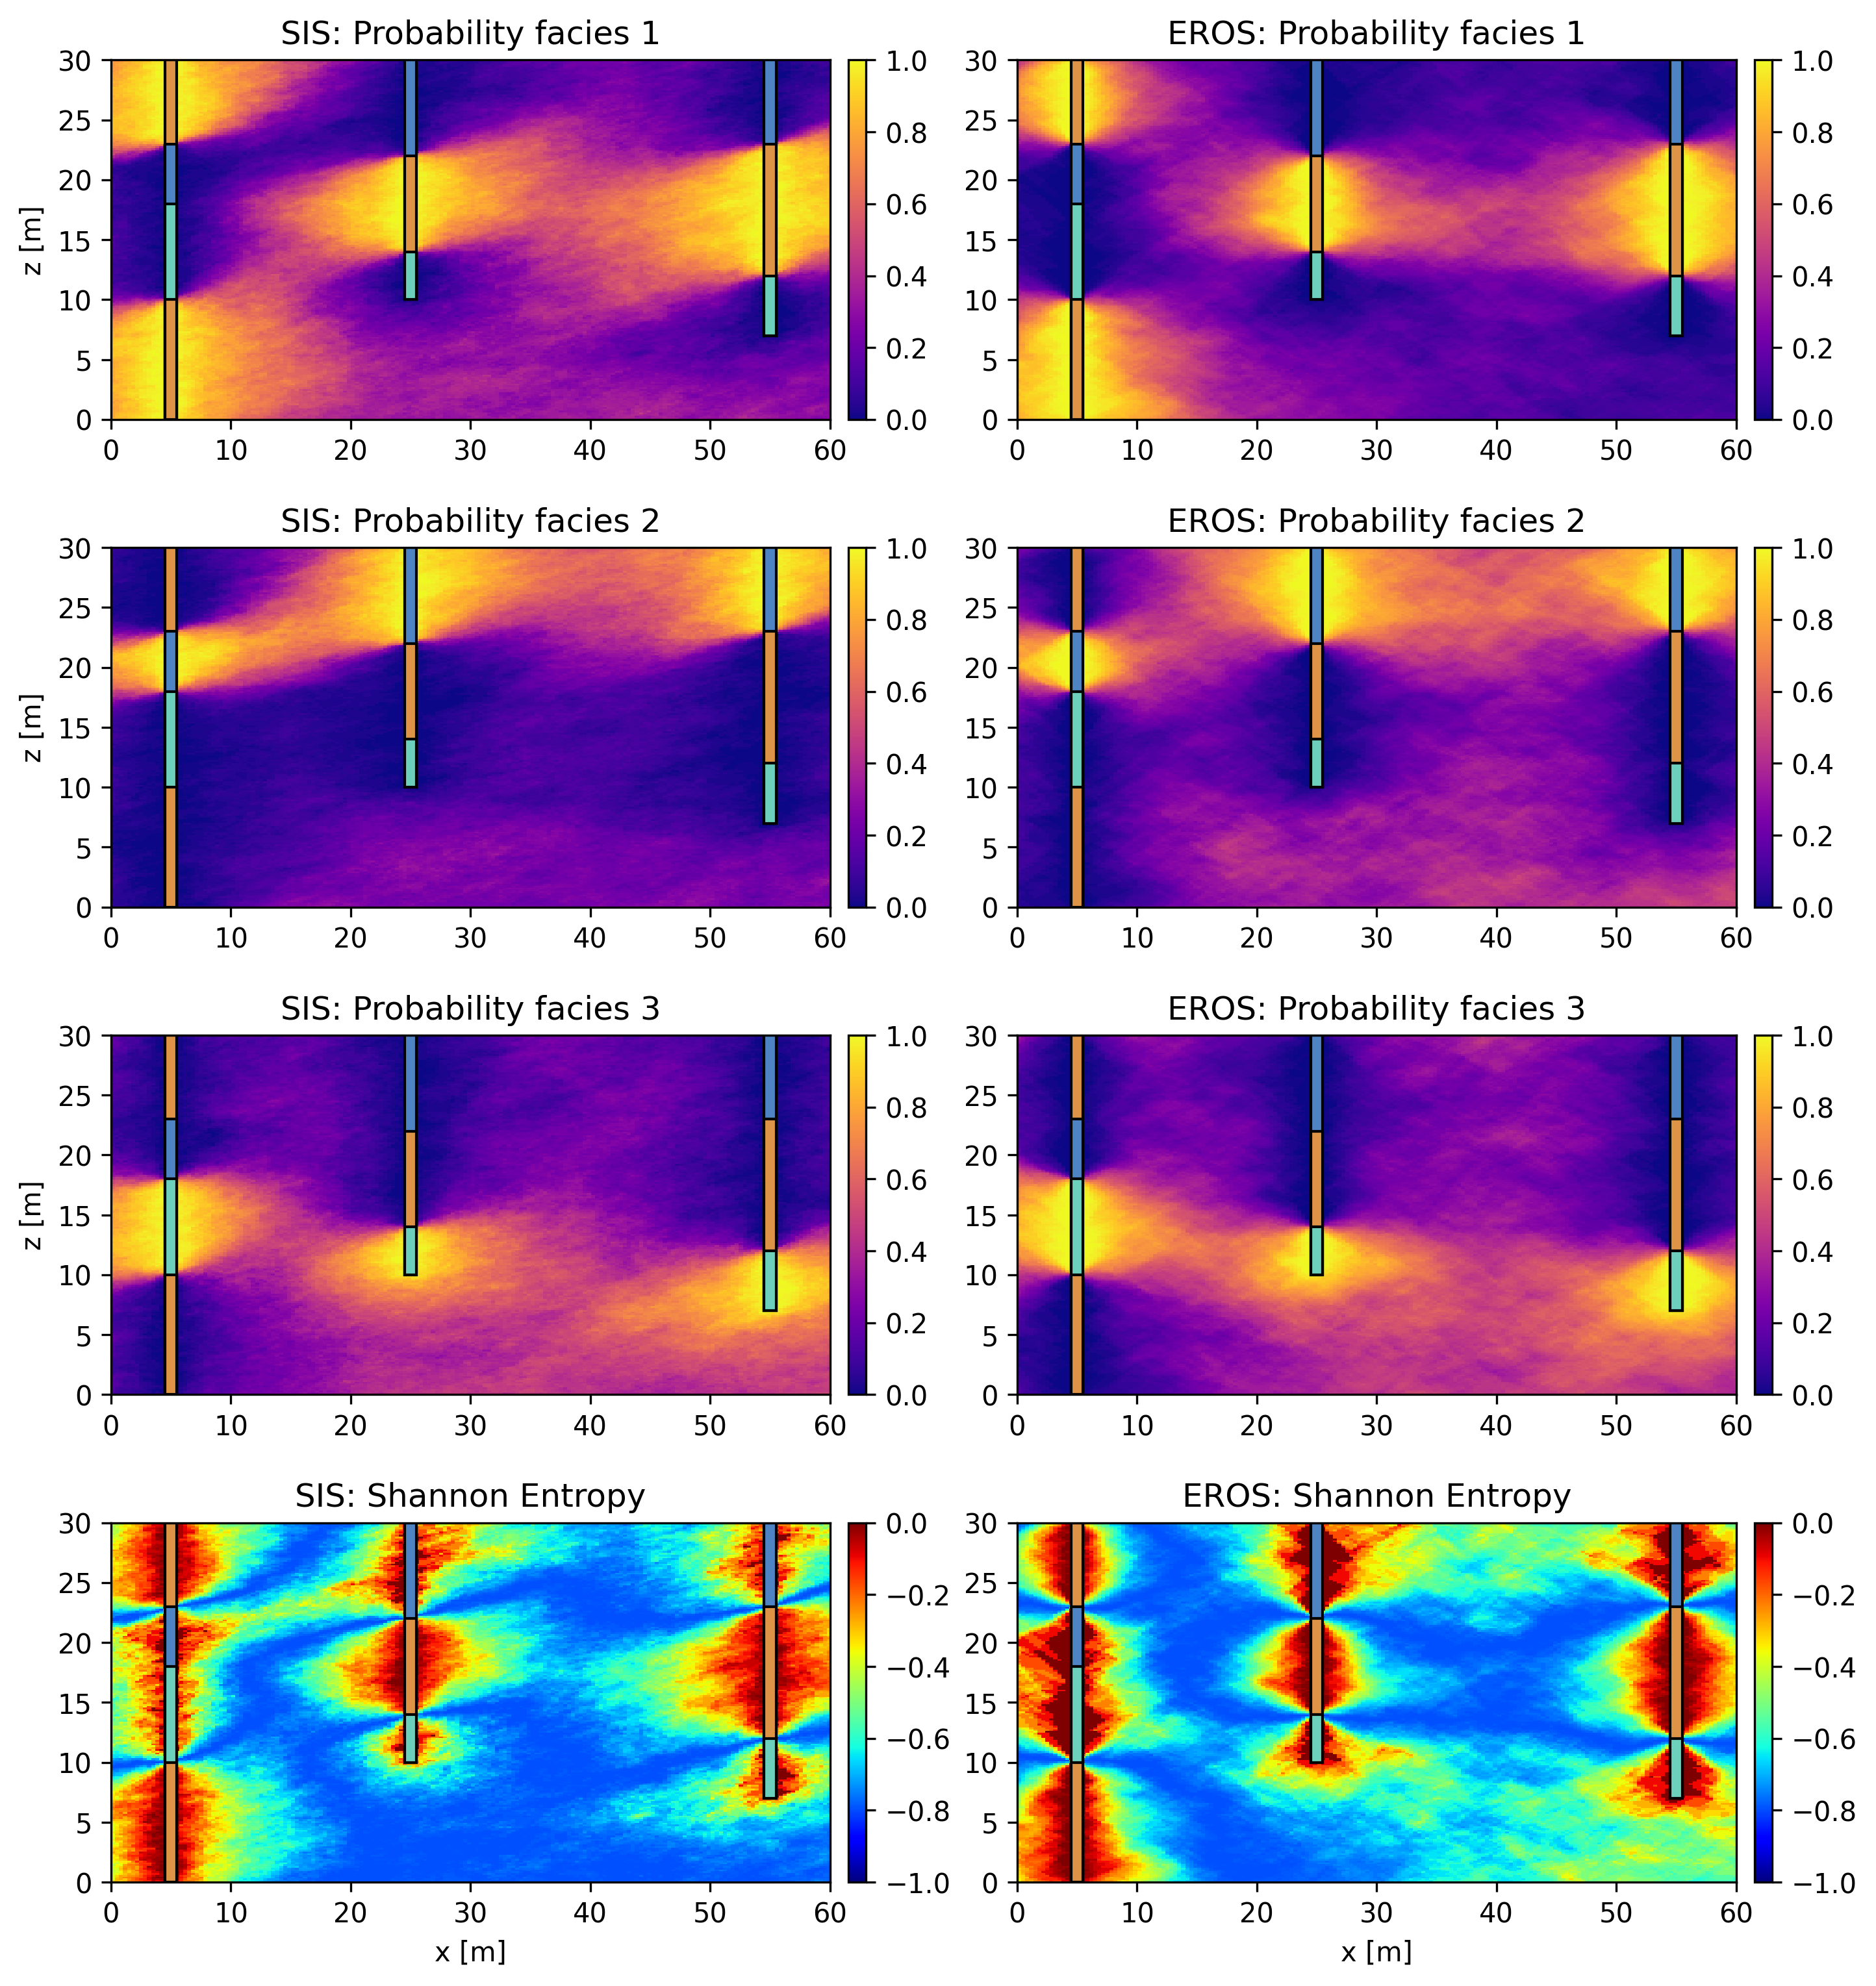

In [26]:
all_sim0_stats = geone.img.imageCategProp(sim_sis, [1, 2, 3])

fig = plt.figure(figsize=(11, 13), dpi=300)
# fig,ax = plt.subplots(4, 2, figsize=(11, 13), dpi=300, sharex=True, sharey=True)
# axes = ax.flatten()

plt.subplots_adjust(hspace=0)
for i in range(3):
    
    plt.subplot(4, 2, i*2+1) # select next sub-plot
    geone.imgplot.drawImage2D(all_sim0_stats, iv=i, cmap="plasma")
    plot_bh(w_logs)
    plt.title("SIS: Probability facies {}".format(i+1))
#     plt.xlabel("x [m]")
    plt.ylabel("z [m]")
    
    
    plt.subplot(4, 2, i*2+2) # select next sub-plot
    
    im = geone.img.Img(nx = arr.shape[1], ny = arr.shape[0], nz=1, sx=sx, sy=sz, sz=1, ox=0, oy=0, oz=0, nv=1,
                       val=np.mean(sims == i+1, 0).reshape(1, 1, nz, nx))
    
    geone.imgplot.drawImage2D(im, cmap="plasma")
    
    #plt.imshow(np.mean(sims == i+1, 0), extent=[ox, x1, oz, z1], origin="lower", interpolation="none", cmap="plasma")
    plt.title("EROS: Probability facies {}".format(i+1))
    plot_bh(w_logs)
#     plt.xlabel("x [m]")
#     plt.ylabel("z [m]")
    
    
## entropy
plt.subplot(4, 2, i*2+3)
arr = np.zeros([nz, nx])
for iv in np.unique(sim_sis.val[:, 0]):
    
    prob = np.mean((sim_sis.val[:, 0] == 1), 0)
    mask = prob > 0
    arr[mask] += prob[mask] * np.log(prob[mask]) / np.log(4)
    
    
im = geone.img.Img(nx = arr.shape[1], ny = arr.shape[0], nz=1, sx=sx, sy=sz, sz=1, ox=0, oy=0, oz=0, nv=1,
                       val=arr.reshape(1, 1, nz, nx))
    
geone.imgplot.drawImage2D(im, cmap="jet", vmax=0, vmin=-1)
plot_bh(w_logs)
plt.xlabel("x [m]")
plt.title("SIS: Shannon Entropy")

## entropy SIS
plt.subplot(4, 2, i*2+4)
arr = np.zeros([nz, nx])
for iv in np.unique(sims):
    
    prob = np.mean((sims == 1), 0)
    mask = prob > 0
    arr[mask] += prob[mask] * np.log(prob[mask]) / np.log(4)
    
im = geone.img.Img(nx = arr.shape[1], ny = arr.shape[0], nz=1, sx=sx, sy=sz, sz=1, ox=0, oy=0, oz=0, nv=1,
                       val=arr.reshape(1, 1, nz, nx))
    
geone.imgplot.drawImage2D(im, cmap="jet", vmax=0, vmin=-1)
plot_bh(w_logs)
plt.xlabel("x [m]")
plt.title("EROS: Shannon Entropy")

In [29]:
# Test with random boreholes to check conditional simulation

np.random.seed(15)
w_logs = []

n_bh = 9

x_bh = []
a = 0
b = 0
for i in range(n_bh):
    
    b += (x1 - ox) / n_bh
    x_bh.append(np.random.uniform(a, b, 1)[0])
    
    a = b

fa_prev = None

for bh in range(n_bh):
    n_fa = np.random.randint(5, 10)
    x = x_bh[bh]
    log = []
    z = z1
    for ifa in range(n_fa):
        fa = np.random.randint(1, 4)
        if fa != fa_prev:
            thk = np.random.normal(2, 1)
            if thk > 0:
                log.append((fa, z))
                z -= thk
                fa_prev = fa
        else:
            pass
    
    w_logs.append((x, z1 - z, log))

(0.0, 30.0)

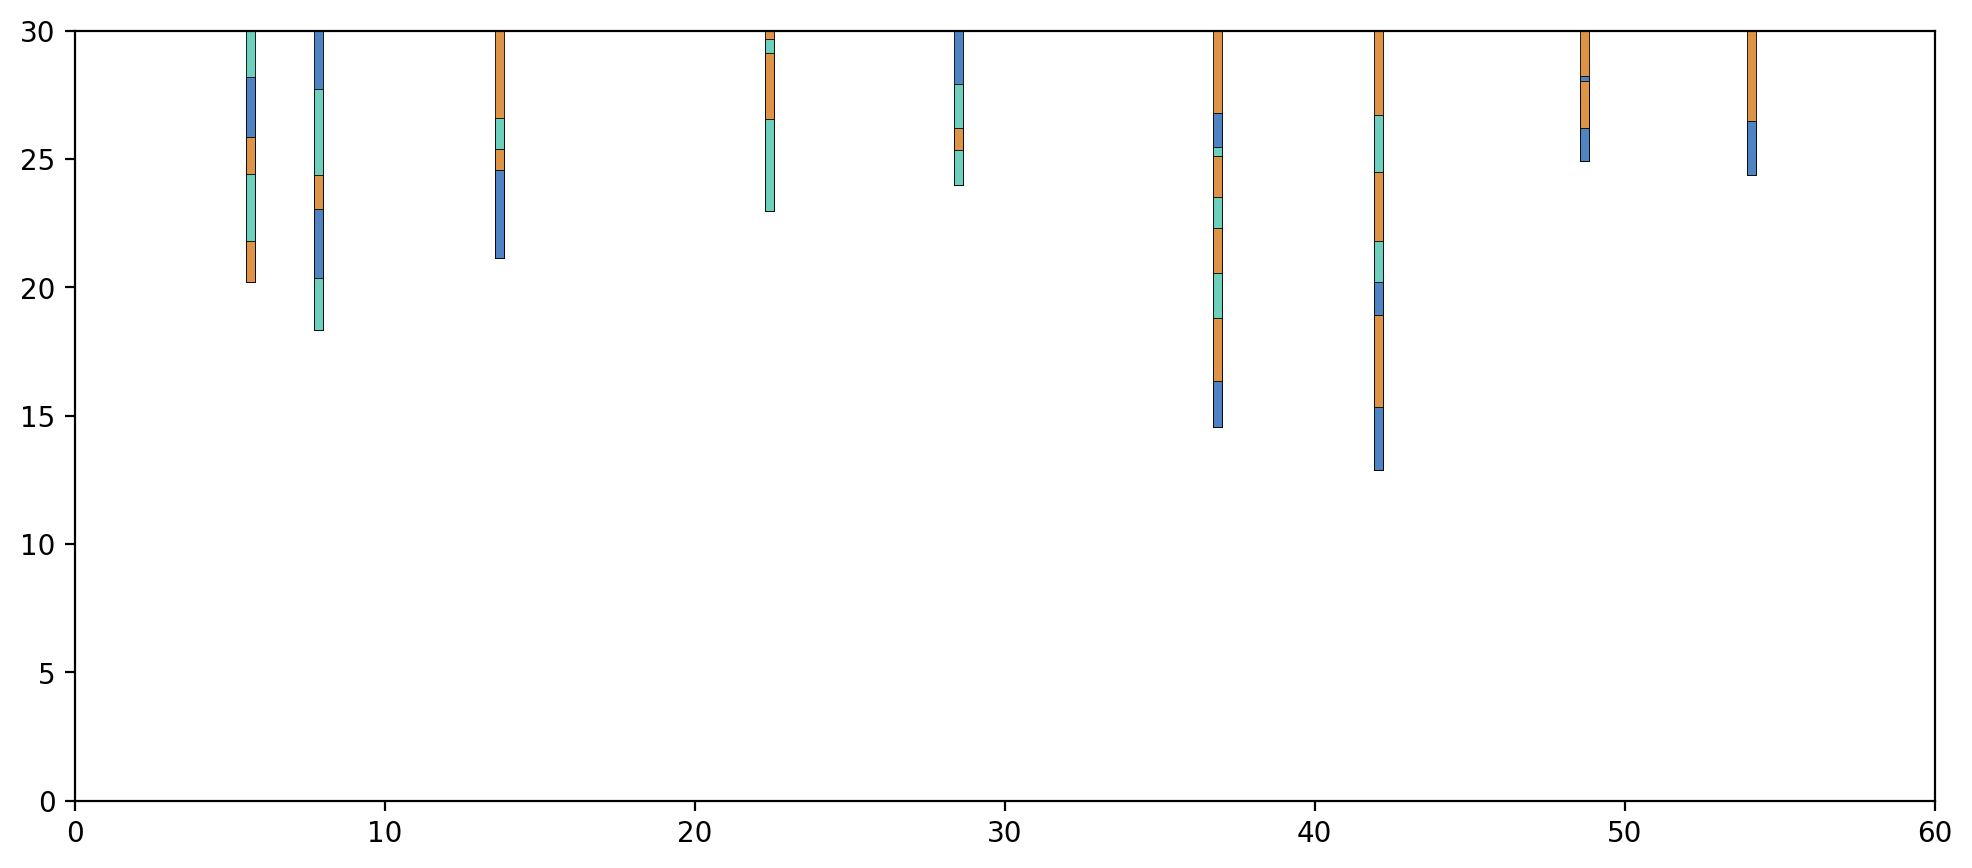

In [30]:
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plot_bh(w_logs, .3)
plt.xlim(0, x1)
plt.ylim(0, z1)


In [31]:
import EROS

In [43]:
%%time

N = 200
np.random.seed(1)
means = np.sort(np.random.uniform(0, z1+5, N))
cm = gcm.CovModel1D(elem=[("cubic", {"w":var, "r":r})])

real_surf, arr_res, list_p_cond = EROS.sim_cond_2D(N, cm, means,
                                      (nx, nz), (sx, sz), (ox, oz), w_logs, alpha=1, 
                                                   xi=0.1, seed=100, plots=False, verbose=1)

161 gne
CPU times: total: 14.9 s
Wall time: 1.12 s


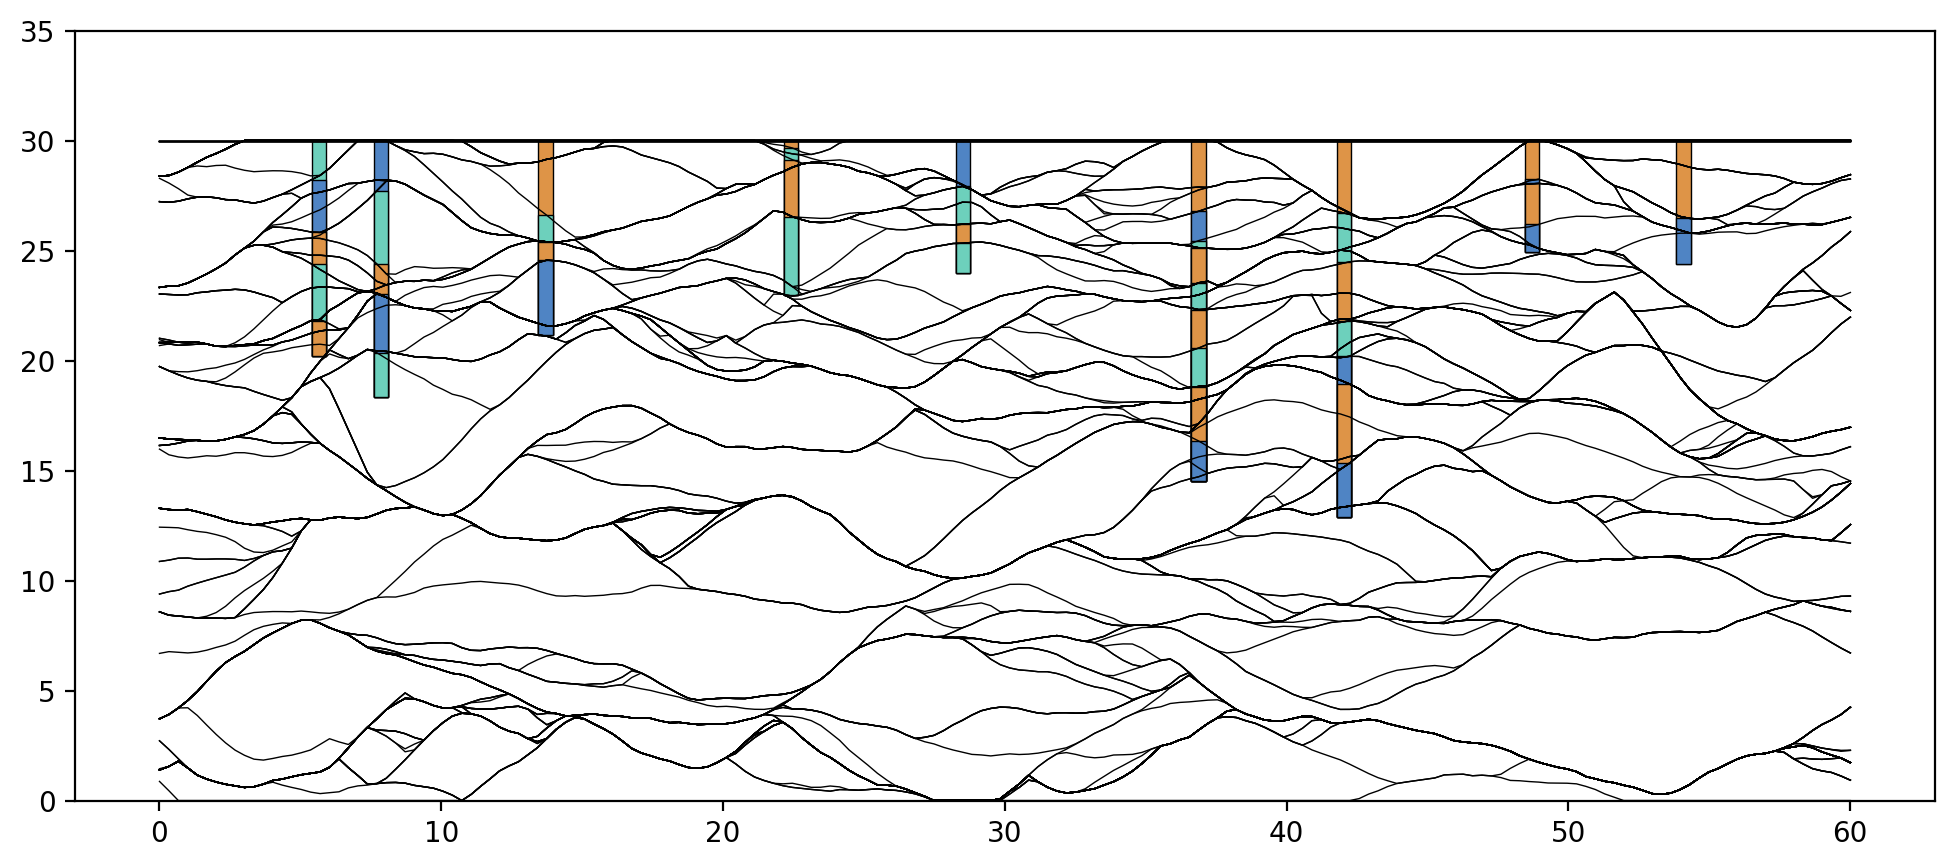

In [44]:
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.5)
plot_bh(w_logs, 0.5)
plt.ylim(0, 35)
plt.show()

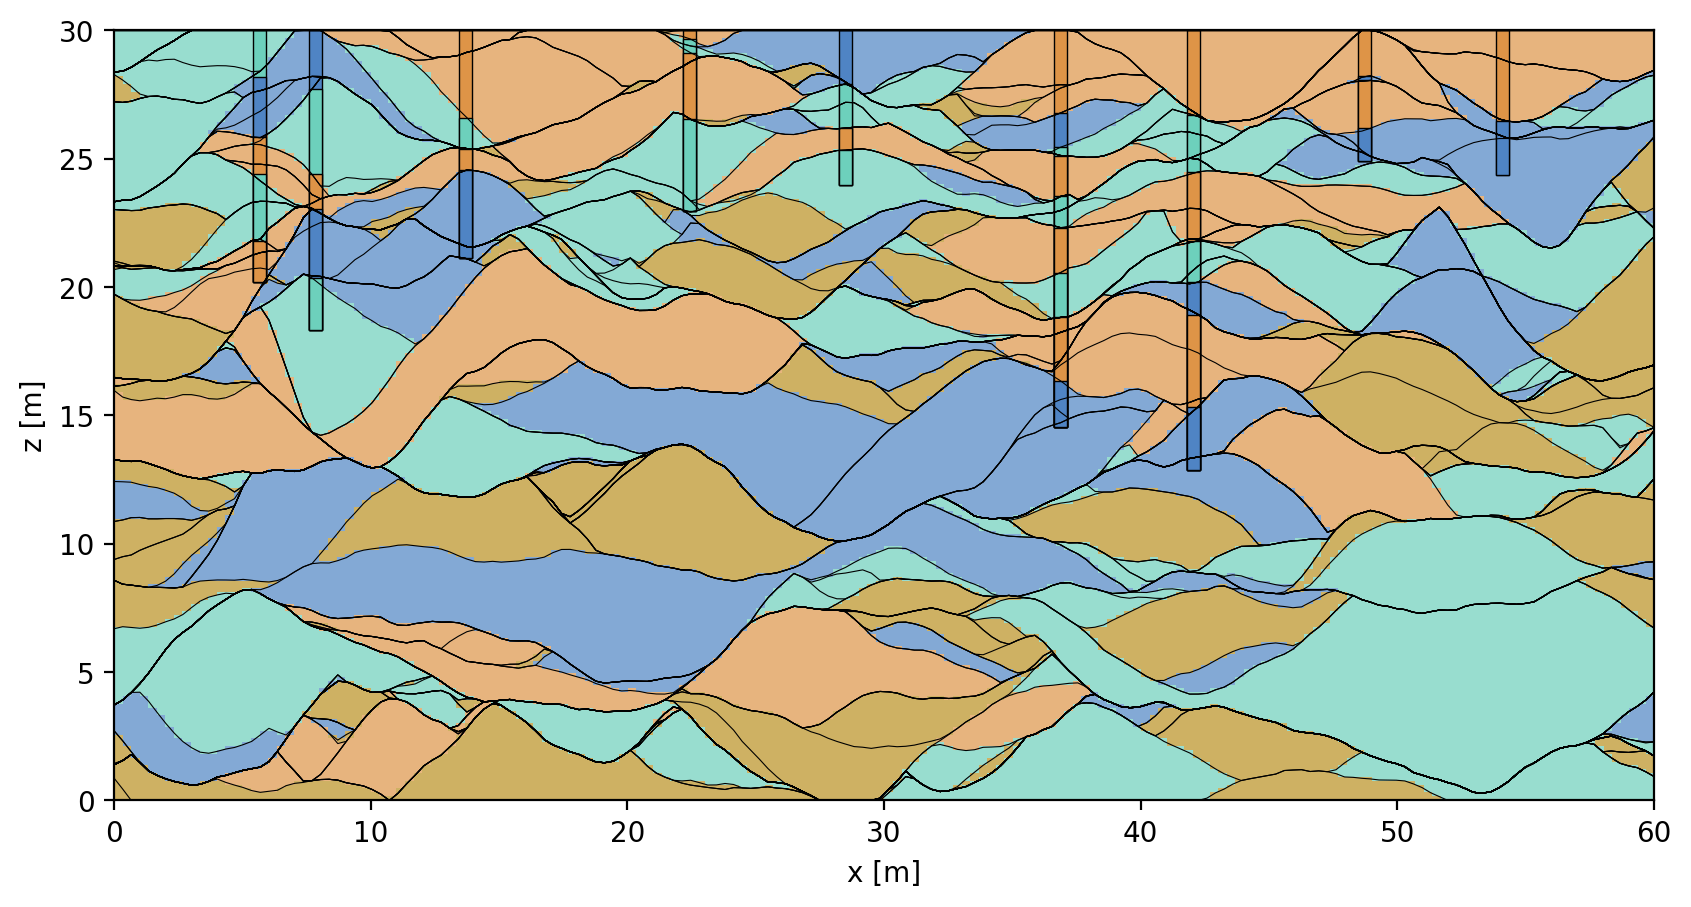

In [45]:
arr_plot = np.zeros([nz, nx, 3])
for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)
    
fig, axs = plt.subplots(figsize=(10,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.4)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plot_bh(w_logs, 0.5)

plt.show()

In [46]:
%%time

N = 200
means = np.sort(np.random.uniform(0, z1+5, N))

real_surf, arr_res, list_p_cond = EROS.sim_uncond_2D(N, cm, means,
                                      (nx, nz), (sx, sz), (ox, oz), alpha=1, 
                                                   xi=0.1, seed=100, verbose=1)

CPU times: total: 7.75 s
Wall time: 518 ms


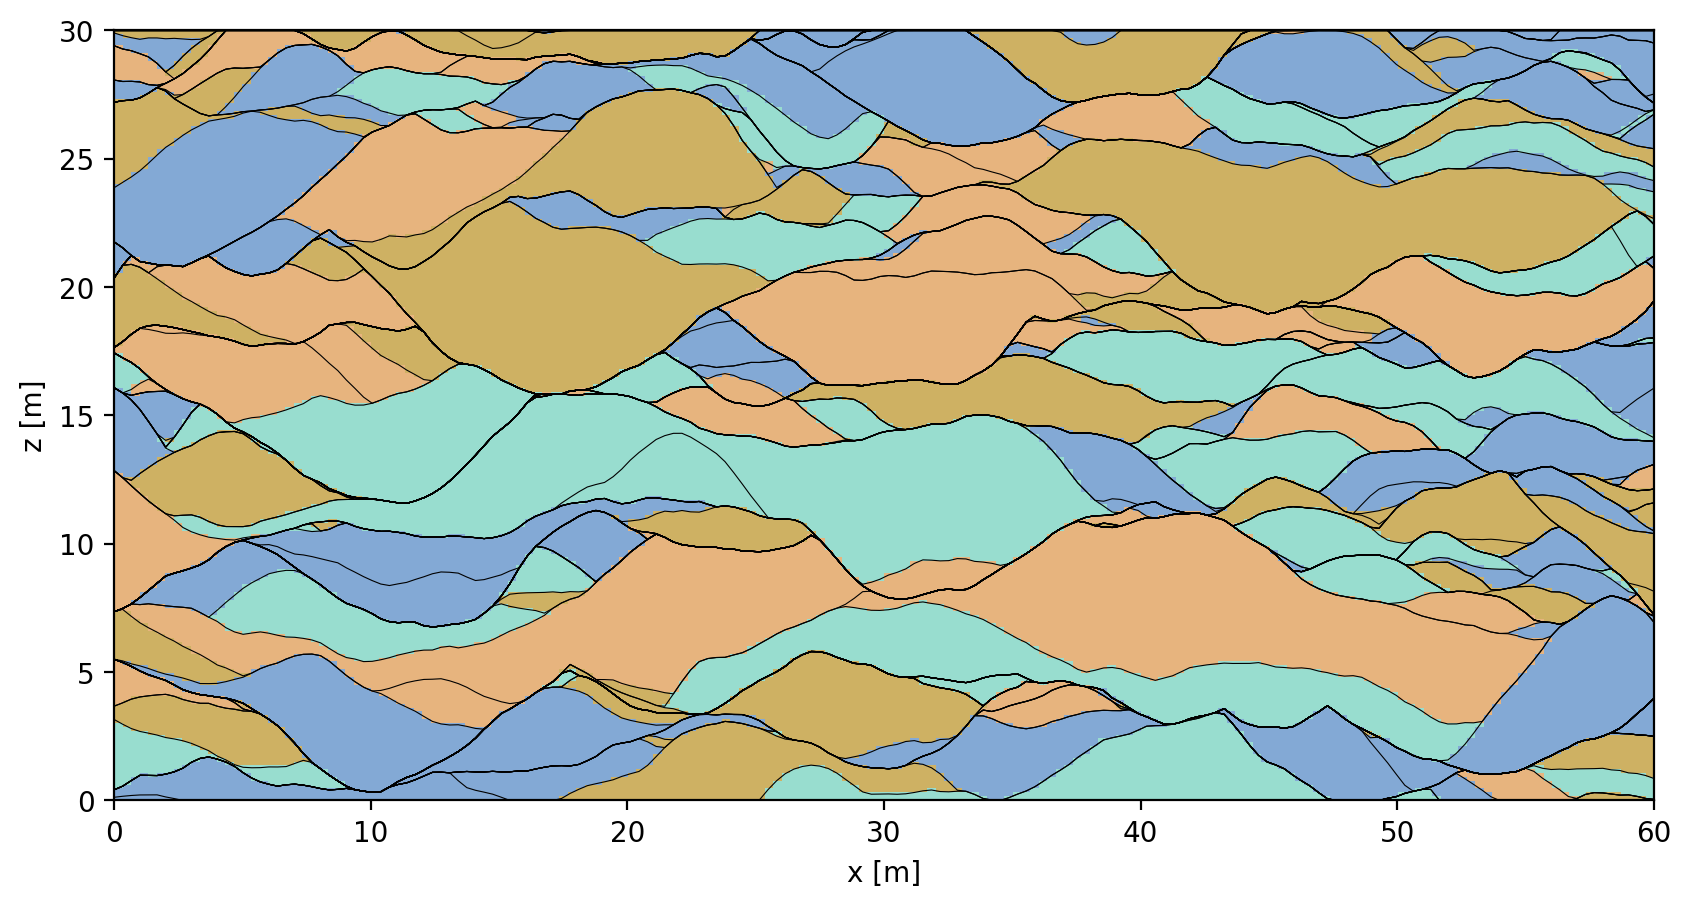

In [47]:
arr_plot = np.zeros([nz, nx, 3])
for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)
    
fig, axs = plt.subplots(figsize=(10,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.4)
plt.xlabel("x [m]")
plt.ylabel("z [m]")

plt.show()